# Ritmični narek

Sistem za preverjanje tocnosti sledenju dolocenemu ritmu. Sistem za vhod pricakuje zvocni posnetek (poljubno) izbrane ritmicne vaje, kjer ritem izgovarjamo na *TA*, *KA* ali *DA*. Obenem moramo definirati tempo vaje in vnesti note; vnesemo jih tako, da podamo seznam not, kjer je vsak element trajanje posamezne note (v dobah). Primer: dve cetrtinki in ena polovinka, bi bila `[1, 1, 2]`. Dve osminki in ena cetrtinka: `[0.5, 0.5, 1]`.

## Some imports

In [2]:
%matplotlib inline

import numpy as np
from scipy.io.wavfile import write, read
from scipy.signal import lfilter

from matplotlib import pyplot as plt
from IPython.display import Audio

## Izbor datoteke

In [4]:
filename1 = 'cetrtinke.wav'
filename2 = 'polovinke.wav'
filename3 = 'osminke.wav'
filename4 = 'osminke-sesnajstinke.wav'

filename = filename3

Audio(filename)

## Določitev ritma in tempa

In [6]:
tempo = 120
rhythm = np.ones(8)  # Cetrtinke
rhythm = np.ones(6) * 2  # Polovinke
rhythm = np.ones(24) * 0.5  # Osminke
# rhythm = np.array([0.5, 0.25, 0.25]*8)  # Osminke-sesnajstinke

tolerance = 0.05

## Izračun natančnosti

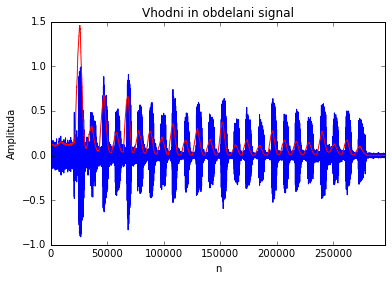

In [7]:
ta = read(filename)
ta = ta[1][:,0] / np.max(ta[1][:,0])

ta = ta[2000:-2000]  # Odrezi zacetek in konec (zacetek snemanja, pritisk miske)
tae = ta

b = np.array([1, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 1])
a = np.array([1, -2, 1])
tae = lfilter(b, a, tae)  # Lowpass filter

h_der = np.array([-1, -2, 0, 2, 1])*(1/8)  # Derivative filter

tae = np.convolve(tae, h_der)
tae *= tae  # Kvadrat

tae = np.convolve(tae, np.ones(4410) / 4410)  # Povprecenje

tae = tae[3400:]  # Zamik (v trenutni implemenaticiji nepomembno - le za plotanje)

plt.plot(ta, 'b', tae, 'r')
plt.title('Vhodni in obdelani signal')
plt.xlim([0, len(ta)])
plt.xlabel('n')
plt.ylabel('Amplituda')

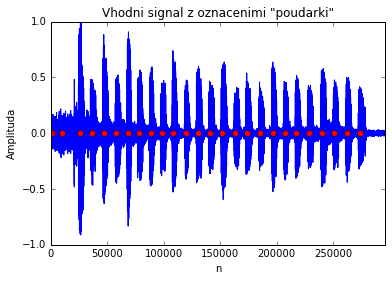

In [10]:
plt.plot(ta)
from peakdetect import peakdetect

peaks = peakdetect(tae, lookahead=2000, delta=0.01)
peaks = np.array([p[0] for p in peaks[0]])
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.title('Vhodni signal z oznacenimi "poudarki"')
plt.xlim([0, len(ta)])
plt.xlabel('n')
plt.ylabel('Amplituda')

## Prikaz natančnosti

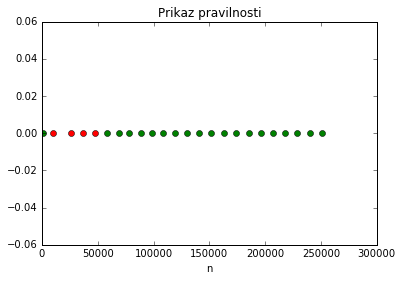

In [11]:
first = peaks[0]  # Dokler nimamo boljsega synca, se uskladimo kar na prvo dobo
n_tempo = 1 / (tempo / 60) * 44100  # Pretvorimo udarcev/minuto v stevilo vzorcev na dobo

diff = (peaks - first) / n_tempo

errors = []

for ind, note in enumerate(rhythm):
    if ind == 0:  # Prva je po definiciji pravilna
        errors.append(0)
        first = False
        continue
    
    if ind >= len(diff):  # Nimamo vec kandidatov za primerjanje
        break

    distance = np.sum(rhythm[:ind])
    curr_err = abs(diff[ind]-distance) / distance
    
    errors.append(curr_err)

colors = []
for ind, note in enumerate(errors):
    if note < tolerance:
        color = 'g'
    else:
        color = 'r'
    plt.plot(peaks[ind], 0, 'o'+color)

plt.title('Prikaz pravilnosti')
plt.xlabel('n')


## Opažanja

Sistem v zelo omejeni obliki deluje pravilno. Ima veliko pomankljivosti, vendar glavni problem resuje ucinkovito - zaznavanje ritma in preracunavanje tocnosti.

Prvotno sem poskusal zaznavati *TA*-je, *KA*-je in *DA*-je s pomocjo energije signala. Vendar se je kmalu izkazalo, da ta metrika sama po sebi ni dovolj, saj je pretezko zaznati vse potrebne 'vrhove', ne da bi zraven zaznali se precej laznih vrhov. Po nekaj poizkusih in iskanju inspiracije na drugih podrocjih (biomedicinski signali), sem ugotovil, da je odvod signala tu zelo uporabna metrika. Ker gledamo odvod, zelimo pred tem signal zgladiti (zato lowpass filter). S kvadriranjem poudarimo vrhove in se znebimo negativnega predznaka. Nazadnje pa s preprostim povprecenjem dobimo precej ocitne vrhove, ki jih lahko zaznavamo z marsikaterim algoritmom za odkrivanje vrhov.  
Se vedno je potrebno malce spreminjati parametre iskanja vrhov od primera do primera (vcasih sistem zazna prevec, vcasih premalo), a razen tega tudi ob okoliskem zvoku, sistem zna pravilno prepoznati ritmicni narek.

Sistem bi se dalo se precej izboljsati. Poleg ocitnih stvari, kot so preprostejsi vnos ritma in zvocne datoteke, so tukaj se mogoce ne tako ocitne izboljsave. Najvecja izboljsava na mestu preracunavanja tocnosti, bi morala biti moznost sledenja metronomu - trenutno se celoten narek ocenjuje glede na prvo zaznano dobo. Super bi bilo, ce bi se lahko vsako noto ocenjevalo posebej; primerjano z nekim metronomom. Tukaj je seveda veliko problemov, glavni izmed njih verjetno usklajevanje signalov.  
Kar se tice zaznavanje vrhov, bi bilo potrebno doseci vecjo robustnost - da ne bi bilo potrebno vec spreminjati parametrov.  
Tudi ocenjevanje pravilnosti bi bilo lahko bolj robustno - trenutno je tako, da ce je vmes zaznan kaksen lazen *TA*, bodo vse nadaljne note verjetno oznacene kot napacne. Prav tako bi bilo super da se preverja se dolzino drzanja note in posledicno tudi pavze. Trenutno se preverja samo ali je nota zaceta ob pravilnem casu.  
Navsezadnje, pa bi bilo super, ce bi tak sistem lahko deloval real-time, za kar pa si niti ne predstavljam kaksne spremembe vse bi bilo potrebno storiti.